### CS986FoMLDAGroup7: Regression Modelling Analysis
Bhaskar Sinha(202359293),  Eitika Sharma(202352860), Akshay Shiwarkar(202387178), Abu Hurairah(202383800), Salman Tahir(202356526)

## Introduction
The analysis aims to predict popularity score of a song based on several features. Since popularity is an integer value, we will employ a regression method. Nonetheless, before diving deeper we need to look at the big picture, get, clean, discover and visualize data for insights. Following this, we will prepare the data for our regression analysis, select and train the model and would ultimately fine-tune it for accuracy. Lastly, we will present our findings and compare with our performance in Kaggle InClass competition. A prime focus of our analysis would be to provide justification for any tool or method we employ.

#### Data Overview:
- Loaded the dataset from "CS98XRegressionTrain.csv".
- Checked the shape of the dataset: (453, 15).
- Checked for missing values: "top genre" column has 15 missing values.
- Dropped rows with missing values, resulting in a dataset shape of (438, 15).

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn import preprocessing, datasets, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
color = sns.color_palette()


In [2]:
df = pd.read_csv("CS98XRegressionTrain.csv")
df.shape

(453, 15)

In [3]:
df.isnull().sum()

Id            0
title         0
artist        0
top genre    15
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
dtype: int64

In [4]:
df2 = df.dropna()
df2.shape

(438, 15)

## Exploratory Data Analysis (EDA)
We have visualized the correlation matrix heatmap to identify relationships between features and the target variable "**pop**".
Following this we plotted scatterplots of each feature against "pop" to examine relationships between two variables, identify trends and patterns, compare groups and set the stage for further data exploration. In addition we have formed histograms to check for central tendency and skeweness.

In [5]:
df2.head(2)

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77


In [6]:
# 'title', 'Id','artist' are object types cateogorical columns so we are making a new df without them to see visualize the correlation of the remaining features with target variable 'pop'
df_eda = df2.drop(['title', 'Id','artist'], axis=1)

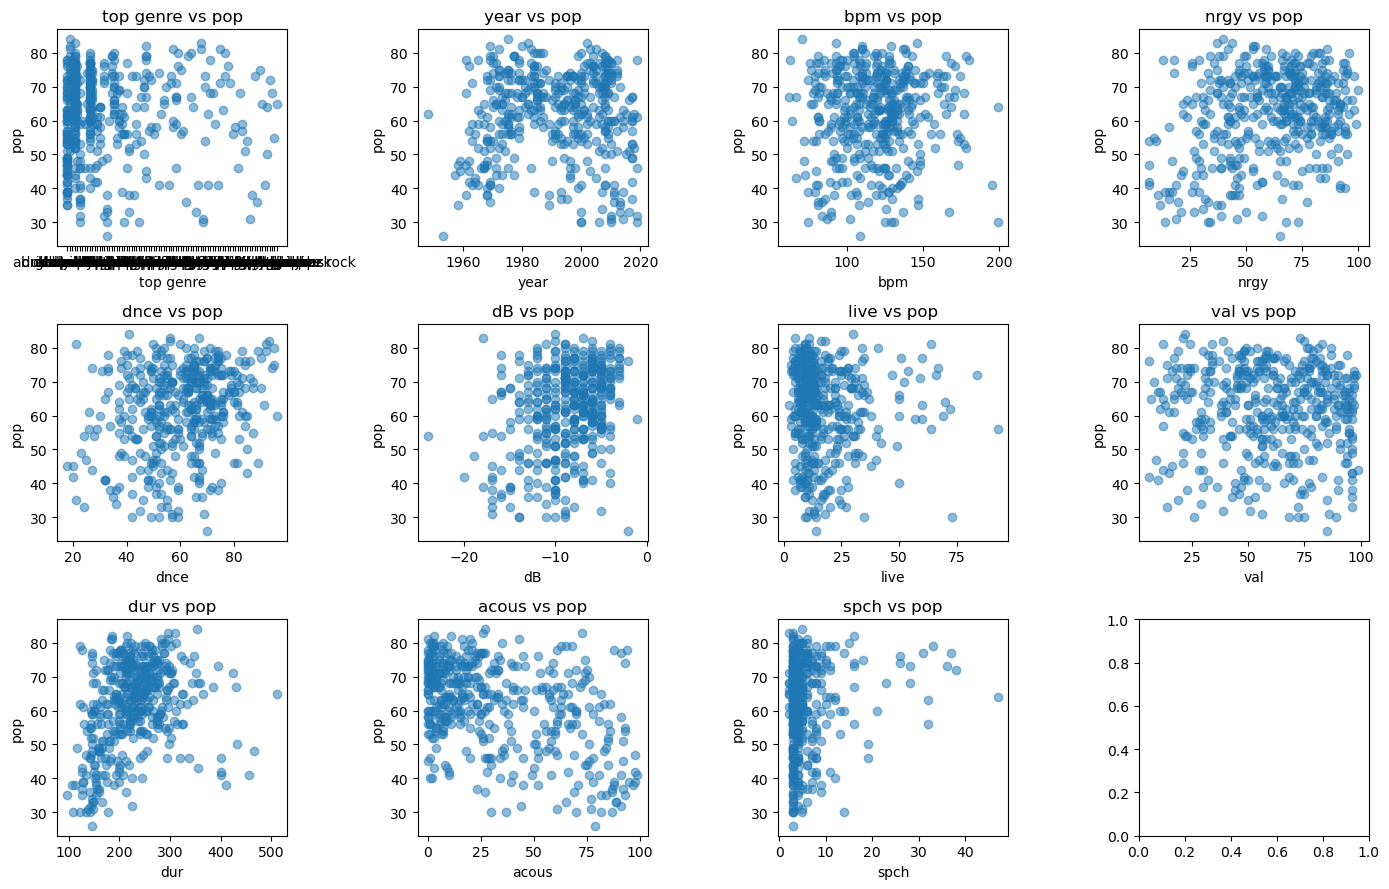

In [7]:
num_cols = 4
fig, axes = plt.subplots(-(-len(df_eda.columns) // num_cols), num_cols, figsize=(14, 3 * -(-len(df_eda.columns) // num_cols)))
for ax, column in zip(axes.flatten(), df_eda.columns):
    if column != 'pop':
        ax.scatter(df_eda[column], df_eda['pop'], alpha=0.5)
        ax.set_title(f'{column} vs pop')
        ax.set_xlabel(column)
        ax.set_ylabel('pop')
plt.tight_layout()
plt.show()

The scatterplots above describes the relations of different features with popularity. It is difficult to ascertain relationship of genres because of the presenceof different varities. However, the others are presented below:
- It is evident that from post 1980s onwards a high volume of songs were popular though till the period leading to 2020 there was a short decrease in the period till middle.
- Similarly 100 to 150 bpm songs were popular and so was the case with nrgy and pop where approx 50 to 90 nrgy songs were popular.
-In addition we can see that in the case of live, spch, acous and dur there was a left concentration approach where the values to the left or lesser values of the features described were popular.
- Whereas in val us pop and dance vs pop the data was concentrated and so conclusive trend could be ascertained.

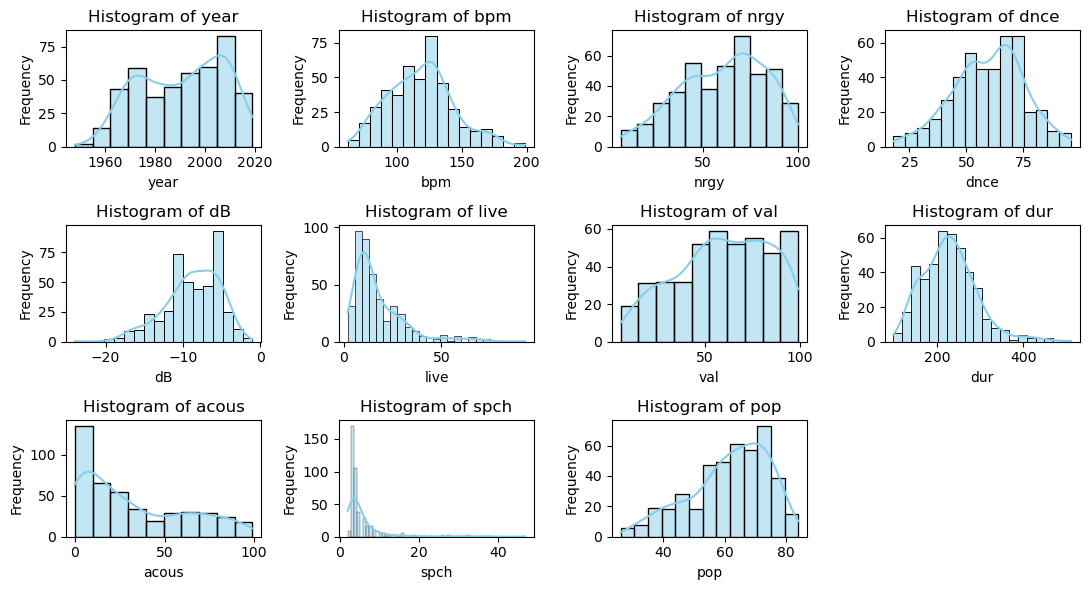

In [8]:
numeric_columns = df_eda.select_dtypes(include='number').columns
num_plots = len(numeric_columns)
num_cols = 4  
num_rows = (num_plots - 1) // num_cols + 1 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(11, 2*num_rows))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    sns.histplot(df_eda[column], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

Finally to get a holistic overview of all the features we plot the relevant histograms and can see some conclusions like:

- the year attribute reveals a fairly even distribution of songs, with a short lived peak in 2000s. This means that the dataset has songs from different eras.
- A big chunk of the songs have beats per minute between approx 65 and 130 which signifies pop music. There are fewer genres that are very slow or very fast.
- An almost even spreadout with slight peaks can be seen in the energy levels of songs which signals that there is a mix of low and high energy songs.
- Most of the songs have danceability score ranging from over 50 to 70, suggesting that they are adequately danceable. The other ranges in this feature has less danceability score.
- Likewise the valuence of songs which is entirely positive suggests presence of upbeat and happy songs.
- The duration of songs suggest that many songs have a medium term duration, not too short and for sure not too long.
- Similar trends can be seen in other features especially spch and pop. Spch reveals that most of the songs has low speechiness and hence there's more singing rather than spoken words whereas pop shows left skewness showing more popular songs has a high frequency.

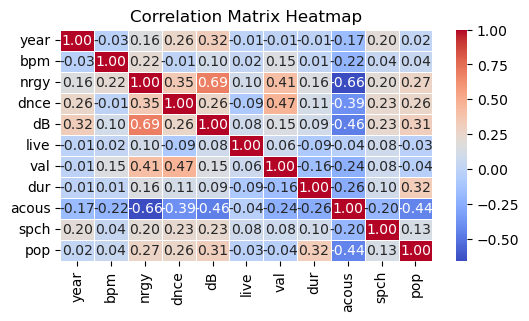

In [9]:
plt.figure(figsize=(6, 3))
sns.heatmap(df_eda.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation matrix heatmap shows correlation between the features and we can draw some conclusions based on this and would drop the features with low correlation:
- db and nrgy has a high correlation of 0.69 signifying that loud songs are more energetic. Also valence of a song are more energetic too.
- Surprisingly acous and nrgy has a high negative correlation meanining the more energetic the song, the less acoustic it is or less able to be heard properly.
- In addition, val and acous has a relatively better correlation with dance which shows that these features add to the fact that it is better to dance on. A similar trend can be seen in acous and dB.
- However, our target variable is pop and we will only keep variables which has a high correlation with pop.

In [10]:
# Dropping unnecessory columns
newdf = df2.drop(["Id","title","year","live","val"], axis=1)

Based on the correlation analysis we are dropping **id**, **title**, **year**, **live** and **val**

## Feature Engineering
In this section we have applied Label Encoding to "top genre" and "artist" columns to convert categorical variables to numerical labels. Next we calculated the correlation of encoded "top genre" and "artist" features with the target variable "pop". Finally the features "artist_encoded" column was dropped as it had low correlation with "pop".

In [11]:
#We are using Label Encoder to create a mapping between the categorical and their respective numerical labels
label_encoder = LabelEncoder()
# Applying label encoding to 'top genre' and 'artist' columns
newdf['top_genre_encoded'] = label_encoder.fit_transform(newdf['top genre'])
newdf['artist_encoded'] = label_encoder.fit_transform(newdf['artist'])
# Now we can use 'artist_encoded', 'top_genre_encoded', along with other features to predict 'pop'
newdf.drop(columns=['top genre'], inplace=True)
newdf.drop(columns=['artist'], inplace=True)

In [12]:
# Computing the correlation of encoded artist feature values with the 'pop' column
correlation_artist = newdf['artist_encoded'].corr(newdf['pop'])
correlation_top_genre = newdf['top_genre_encoded'].corr(newdf['pop'])
print("Correlation of 'artist' with 'pop':", correlation_artist)
print("Correlation of 'top genre' with 'pop':", correlation_top_genre)
print("We can see that', 'artist_encoded', 'has very low correlation' ,'so we will drop that column.")

Correlation of 'artist' with 'pop': -0.03720036536254422
Correlation of 'top genre' with 'pop': 0.17101636512329965
We can see that', 'artist_encoded', 'has very low correlation' ,'so we will drop that column.


In [13]:
newdf = newdf.drop(['artist_encoded'], axis=1)
newdf.columns

Index(['bpm', 'nrgy', 'dnce', 'dB', 'dur', 'acous', 'spch', 'pop',
       'top_genre_encoded'],
      dtype='object')

### Outlier Handling
We identified outliers using boxplots and performed a Box-Cox transformation on the "spch" and "dur" columns to stabilize variance and approximate a normal distribution. We then utilized a Robust Scaler to scale the features, which is robust to outliers.

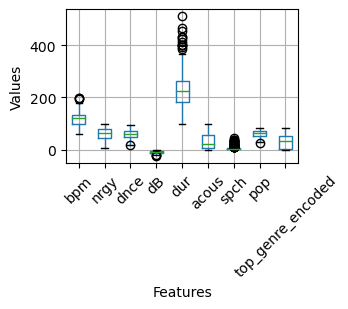

In [14]:
newdf.boxplot(figsize=(3, 2), rot=45); plt.xlabel('Features'); plt.ylabel('Values'); plt.show()

We can see that the 'dur' and 'spch' having most outliers.
Hence we will perform boxcox transformation to stabilize variance and make selected columns more closely approximate a normal distribution.

In [15]:
from scipy.stats import boxcox
# Perform Box-Cox transformation on 'spch' and 'dur' columns
newdf['spch_transformed'], spch_lambda = boxcox(newdf['spch'] + 1)  # Adding 1 to handle zero values
newdf['dur_transformed'], dur_lambda = boxcox(newdf['dur'] + 1)  # Adding 1 to handle zero values
# Drop original 'spch' and 'dur' columns
newdf.drop(columns=['spch', 'dur'], inplace=True)

Below results show the aituation after box cox transformation of on 'spch' and 'dur' column in which outliers are normalized.

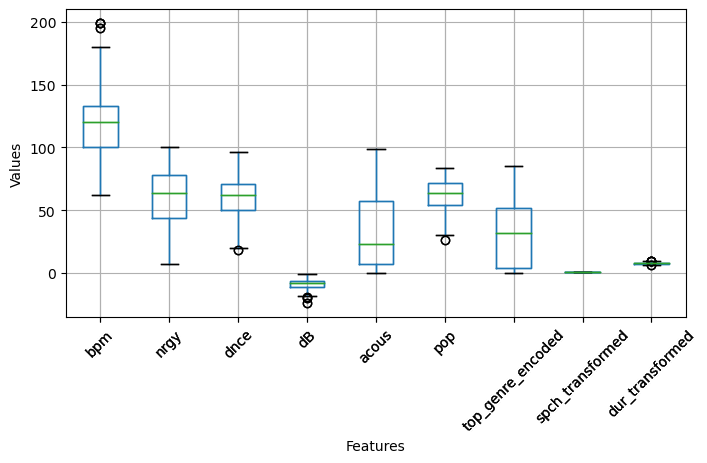

In [16]:
newdf.boxplot(figsize=(8, 4), rot=45)
newdf.boxplot(figsize=(8, 4), rot=45); plt.xlabel('Features'); plt.ylabel('Values'); plt.show()

Moving ahead, the features in our dataset have different scales or units,so we will use scaling. In our case we will use Robust Scaler as it is robust to outliers.

In [17]:
# Select all columns except 'pop' for scaling
columns_to_scale = [col for col in newdf.columns if col != 'pop']
scaler = RobustScaler()
newdf[columns_to_scale] = scaler.fit_transform(newdf[columns_to_scale])

C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_16044\580337512.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


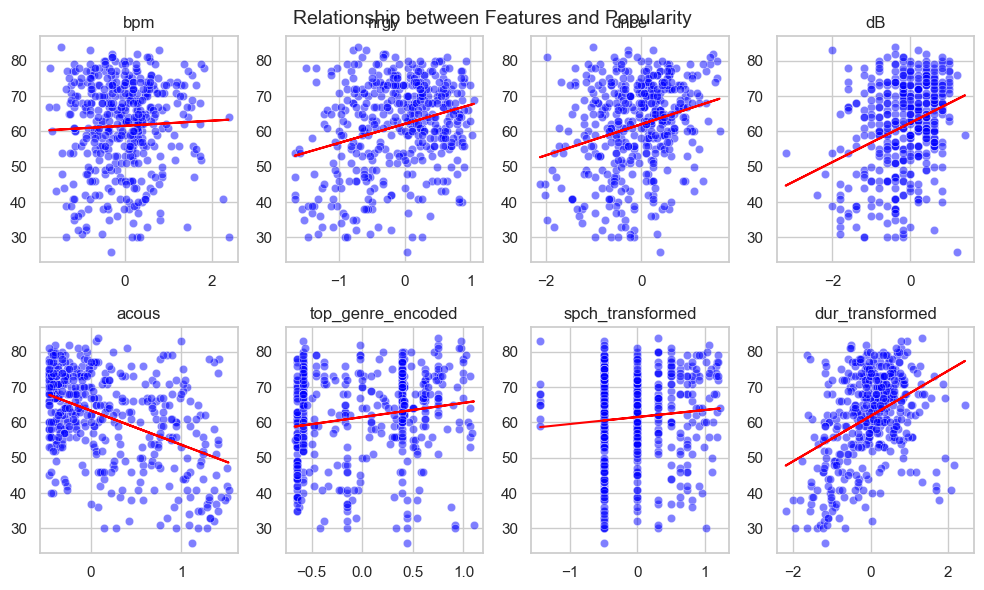

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
features = ['bpm', 'nrgy', 'dnce', 'dB', 'acous', 'top_genre_encoded', 'spch_transformed', 'dur_transformed']
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.scatterplot(x=feature, y='pop', data=newdf, alpha=0.5, color='blue')
    b, m = polyfit(newdf[feature], newdf['pop'], 1)
    plt.plot(newdf[feature], b + m * newdf[feature], color='red')
    plt.title(f'{feature}')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
plt.suptitle('Relationship between Features and Popularity', fontsize=14)
plt.show()

The scatterplots above shows the transformed scatterplots of popularity and features with respect to linearity. It shows no evident relationship between any of the features with popularity and predicts an inconclusive result. For instance there is popular songs with low and high bpm and the same is true for other features.

Following scaling, we will observe the correlation of all festures with respect to **pop**

In [19]:
print(newdf.corr()['pop'])
print("We will drop 'bpm' column as it has very low correlation") 

bpm                  0.042695
nrgy                 0.274006
dnce                 0.256099
dB                   0.312952
acous               -0.443763
pop                  1.000000
top_genre_encoded    0.171016
spch_transformed     0.088697
dur_transformed      0.386621
Name: pop, dtype: float64
We will drop 'bpm' column as it has very low correlation


# Model Building
The most important step of our exercise is model building and here we will split the dataset into training and test sets. 

**Rationale for KNN**
Initially, we will do KNN because it is viable when there is no true relationship or when the relationship is complex or unknown. This is evident from the EDA we performed above. In addition, KNN is flexible for local patterns as it is better in adaptability and avoids the need for complex feature engineering. 


Besides this, we will evaluate the performance of each model using metrics like RMSE, MAE, R-square and explained variance score.


In [20]:
from sklearn.model_selection import train_test_split
X = newdf.drop(columns=['pop', 'bpm']) # Features (all columns except 'pop' and 'bpm')
y = newdf['pop']  #target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print("RMSE for KNN model:", rmse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print("MAE for KNN model:", mae_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("R-squared for KNN model:", r2_knn)
explained_variance_knn = explained_variance_score(y_test, y_pred_knn)
print("Explained Variance Score for KNN model:", explained_variance_knn)

RMSE for KNN model: 9.72655689804512
MAE for KNN model: 7.6431818181818185
R-squared for KNN model: 0.3619772198220119
Explained Variance Score for KNN model: 0.3620416292556077


Our model achieved a Root Mean Squared Error (RMSE) of 9.73, signifying that, on average, our predictions deviated by 9.73 from the true values. This error appears to be relatively high, particularly given the scale of the data. The Mean Absolute Error (MAE) is 7.64, indicating an average prediction deviation of 7.64 from the true values—another relatively high error. The R-squared value stands at 0.362, suggesting that our model explains 36.2% of the variance in the data. This relatively low R-squared value implies that the model does not fit the data well. The Explained Variance Score mirrors the R-squared value at 0.362 and shares its interpretation.

Hence for better results we would not stick with KNN and move to another model: **SVM**

**Rational for using SVM**
From KNN we moved to using SVM to minimize our error between the predicted and actual values with a margin of tolerance as KNN failed to do that. SVM has an edge in handling both linear and non-linear relationships; and outliers effectively.


In [22]:
svm_model = SVR(kernel='linear').fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
explained_variance_svm = explained_variance_score(y_test, y_pred_svm)
print(f"RMSE for SVM model: {rmse_svm}\nMAE for SVM model: {mae_svm}\nR-squared for SVM model: {r2_svm}\nExplained Variance Score for SVM model: {explained_variance_svm}")

RMSE for SVM model: 9.719538679321946
MAE for SVM model: 7.673595776982657
R-squared for SVM model: 0.36289762115031166
Explained Variance Score for SVM model: 0.36413146965591103


Surprisingly, SVM bade poorly as well and we do not see any marked change in the results so we will try to use ensemble methods.
**Rationale for ensemble methods**: They can reduce variance and can capture complex patterns in the data and provide more accurate predictions.


#### Ensemble Methods
1. **Random Forests** are known for their ability to handle non-linear relationships, robustness to overfitting, and ease of use, which might improve metrics with respect to SVM.


In [23]:
rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
explained_variance_rf = explained_variance_score(y_test, y_pred_rf)
print(f"RMSE for Random Forest model: {rmse_rf}\nMAE for Random Forest model: {mae_rf}\nR-squared for Random Forest model: {r2_rf}\nExplained Variance Score for Random Forest model: {explained_variance_rf}")

RMSE for Random Forest model: 9.307667843333162
MAE for Random Forest model: 6.896931818181819
R-squared for Random Forest model: 0.41574871681882186
Explained Variance Score for Random Forest model: 0.42355379633346946


Based on our evaluation of RMSE and MAE, the Random Forest model demonstrates superior performance, yielding a lower RMSE of 9.3077 and a lower MAE of 6.8969. This indicates that, on average, our Random Forest model makes smaller prediction errors compared to the SVM model.

Similarly the results of R-squared and explained variance score, in comparison with SVM reveals our choice of using random forest was a better choice

2. **Tuning Gradient Boosting model** We extend our analysis beyond Random Forest to explore Gradient Boosting, to further improve our accuracy. IGradient Boosting excels in identifying crucial data features, improving interpretability. Through precise tuning of hyperparameters using GridSearchCV, we attain an optimal balance, surpassing the accuracy of Random Forest. In essence, we craft a model that comprehensively understands data nuances, ensuring precise predictions and valuable insights. Leveraging the full potential of Gradient Boosting significantly enhances our predictive capabilities

In [24]:
param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'subsample': [0.8, 1.0]}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model, best_params = grid_search.best_estimator_, grid_search.best_params_
y_pred = best_model.predict(X_test)
rmse, mae, r2 = np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print(f"RMSE: {rmse}\nMAE: {mae}\nR-squared: {r2}\nBest parameters: {best_params}")

RMSE: 9.194261241979326
MAE: 6.779486285418884
R-squared: 0.4298992651603397
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 1.0}


Random Forest and Gradient Boosting demonstrate superior scores in our evaluation. However, it is important to note that the Gradient Boosting algorithm has a drawback—it demands substantial computing power for efficient operation.

Moving forward, we will import the Test dataset and proceed with the same feature scaling and transformations applied to the training dataset.

In [25]:
rf = pd.read_csv("CS98XRegressionTest.csv")
tf = rf.drop(["Id","title","artist","year","live","val","bpm"], axis=1)
tf['top_genre_encoded'] = label_encoder.fit_transform(tf['top genre'])
tf.drop(columns=['top genre'], inplace=True)
tf['spch_transformed'] = boxcox(tf['spch'] + 1)[0]
tf['dur_transformed'] = boxcox(tf['dur'] + 1)[0] 
tf.drop(columns=['spch', 'dur'], inplace=True)
tf[:] = RobustScaler().fit_transform(tf)

In [26]:
tf.head(2)

,nrgy,dnce,dB,acous,top_genre_encoded,spch_transformed,dur_transformed
0,0.930556,0.400000,0.869565,-0.411111,0.217391,0.978152,-0.032530
1,-0.569444,-1.466667,-1.217391,0.144444,0.695652,-0.517849,0.833757


#### Final Model Selection
We chose the Random Forest model because it yielded the best RMSE on the test set. We then generated predictions on the test dataset using the Random Forest model and saved the results to a CSV file for our reference.

In [27]:
# Predictions with Random Forest Model
final = pd.DataFrame({"Id": rf["Id"], "pop": rf_model.predict(tf)})
final.to_csv("PredictRF6.csv", index=False)

In [28]:
# Predictions with Gradient Boosting Model
final = pd.DataFrame({"Id": rf["Id"], "pop": best_model.predict(tf)})
final.to_csv("PredictGB.csv", index=False)

## Conclusion: Comparison with Kaggle Inclass Competition Results:
We started with KNN and moved towards SVM and finally Random Forest regression model which outperformed various algorithms, showcasing its efficacy in predicting song popularity through diverse features. Consequently, we have chosen the Random Forest model as the preferred option for this task. The predicted values (Y_pred) from the Random Forest model have been stored in the PredictRF6.csv file for subsequent analysis and utilization.

In the Kaggle Class Competition our RSME score is 7.5 for random forest model while the same on our train dataset is 9.30. The difference is because of the test and train dataset and we stand at ranking 19. We have significantly improved our ranking among our class members and have raised from ranking 44.
